# Week 8 - Advanced Machine Learning

## Active learning

Active learning is related to semi-supervised learning, with active learning being a more iterative process. The algorithm chooses which samples to request labels for. This can be a very useful approach when many samples are available but labelling them is expensive.

The goal with active learning is to choose a set of samples to label that would most improve the performance of the model. There are a variety of different ways the samples can be chosen:

* Distributed across the feature space
* Uncertainty
* Disagreement between multiple models
* Potential for model change
* . . . and many others

Examples can be found in [compound screening](http://www.ncbi.nlm.nih.gov/pubmed/26840049), [data mapping](http://www.ncbi.nlm.nih.gov/pubmed/26793094), and [study categorization](http://www.ncbi.nlm.nih.gov/pubmed/26262175).

We will look at a simple example of distributing training examples across the feature space . . .

Many of the components used here will be familiar, we are simply using them for a different purpose.

In [1]:
from sklearn import datasets, decomposition

diabetes = datasets.load_diabetes()

X = diabetes.data
y = diabetes.target

In [2]:
pca = decomposition.PCA()
pca.fit(X)
transformed = pca.transform(X)
print(transformed.shape)

(442, 10)


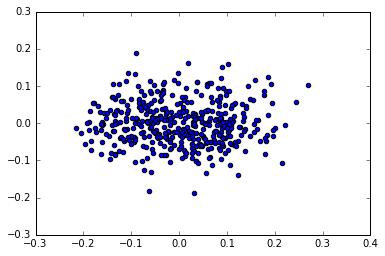

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(transformed[:,0], transformed[:,1])
plt.show()

In [9]:
from sklearn import cluster

kmeans = cluster.KMeans(8)

kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
kmeans.cluster_centers_.shape

(8, 10)

The k-means clustering approach generates a center value for each cluster but this is not a sample from the original data. The code below finds the sample in the original data that is closest to each center.

In [11]:
import numpy as np
centers = []
for i in range(kmeans.cluster_centers_.shape[0]):
    difference = (X - kmeans.cluster_centers_[i]) ** 2
    difference = difference.sum(axis=1)
    centers.append(np.argmin(difference))
print(centers)

[302, 386, 240, 314, 283, 383, 236, 232]


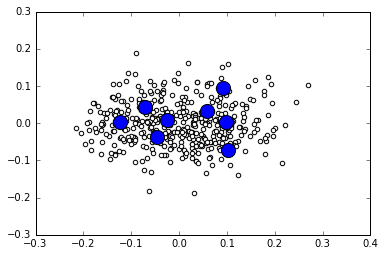

In [12]:
plt.scatter(transformed[:,0], transformed[:,1], color='w', edgecolor='k')
plt.scatter(transformed[centers,0], transformed[centers,1], s=200)
plt.show()

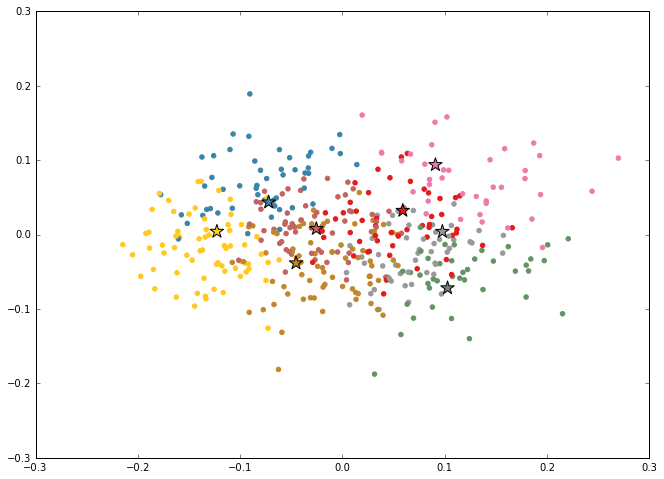

In [13]:
# Improvement on above figure?

fig, ax = plt.subplots(1,1, figsize=(11,8))

color_scale = np.linspace(0, 1, len(set(kmeans.labels_)))

ax.scatter(transformed[:,0], transformed[:,1], 
           color= [plt.cm.Set1(color_scale[i]) for i in kmeans.labels_], )

ax.scatter(transformed[centers,0], transformed[centers,1], 
            color = [plt.cm.Set1(color_scale[i]) for i in range(8)], 
            marker='*', s=200, edgecolors='k')

plt.show()

In [25]:
# Putting everything together and looking at performance

from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics

starting_points = 8

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345)

# Assessing performance without active learning
clf = linear_model.LinearRegression()

clf.fit(X_train[:starting_points], y_train[:starting_points])

y_predicted = clf.predict(X_test)
print('Eight randomly chosen points gives an error =', metrics.mean_squared_error(y_test, y_predicted))


# Now with active learning
kmeans = cluster.KMeans(starting_points, random_state=12345)
kmeans.fit(X_train)

centers = []
for i in range(kmeans.cluster_centers_.shape[0]):
    difference = (X_train - kmeans.cluster_centers_[i]) ** 2
    difference = difference.sum(axis=1)
    centers.append(np.argmin(difference))


clf = linear_model.LinearRegression()

clf.fit(X_train[centers], y_train[centers])

y_predicted = clf.predict(X_test)
print('Eight evenly distributed points gives an error =', metrics.mean_squared_error(y_test, y_predicted))

Eight randomly chosen points gives an error = 70692.5656243
Eight evenly distributed points gives an error = 44389.0156644


## Random actions and the 'average' case

Active learning will speed up the learning process in **most** cases. The price we pay for this is increased variability in the outcome. 

At best, we will be able to train an effective model in **far fewer** samples. On average, we will train an effective model in **slightly fewer** samples. In the worse-case scenario, we will get **worse** performance. For any active learning approach we can encounter a malicious dataset, either by design or chance, that causes the approach to make the worse choices.

In many instances the advantages can be worth the risks, but there is nothing wrong with choosing samples at random. A random element can safeguard against many unexpected situations.

## Dedicated packages

In the section above we walked through applying a very simple example of active learning to a simple dataset. There are more developed approaches we can implement from the literature. In some cases exisiting packages can also be used.

[Libact](http://libact.readthedocs.io/en/latest/index.html) implements several different learning strategies and interacts closely with scikit-learn.